In [1]:
"""
Notebook 1: Exploratory Data Analysis and Preprocessing
Dataset: Knee Osteoarthritis Severity Grading (Chen et al., 2018)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import json
from collections import Counter
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment setup complete!")

Environment setup complete!


In [2]:
# Cell 2: Dataset Overview
"""
Dataset Information:
- Source: Mendeley Data (DOI: 10.17632/56rmx5bjcr.1)
- Author: Pingjun Chen, 2018
- Total Images: 8,164 knee X-rays
- Classes: 5 (KL Grades 0-4)
- Format: PNG images
"""

# Your structure: ../data/train/0/*.png etc.
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

split = 'train'  # Change to 'val' or 'test' as needed!
SPLIT_DIR = DATA_DIR / split
metadata_file = PROCESSED_DIR / f'{split}_metadata.csv'

data = []
for grade in range(5):
    grade_dir = SPLIT_DIR / str(grade)
    if grade_dir.exists():
        for img_path in grade_dir.glob('*.png'):
            data.append({
                'image_path': str(img_path.resolve()),
                'grade': grade,
                'filename': img_path.name
            })

if data:
    df = pd.DataFrame(data)
    df.to_csv(metadata_file, index=False)
    print(f"Created metadata: {len(df)} samples for {split}")
    display(df.head())
else:
    print(f"No data found for split '{split}' in path {SPLIT_DIR}")

Created metadata: 5778 samples for train


,image_path,grade,filename
0,/sda/usama/Indivisual_Analysis/DL_Proj/data/tr...,0,9697904L.png
1,/sda/usama/Indivisual_Analysis/DL_Proj/data/tr...,0,9710415L.png
2,/sda/usama/Indivisual_Analysis/DL_Proj/data/tr...,0,9456499R.png
3,/sda/usama/Indivisual_Analysis/DL_Proj/data/tr...,0,9709164L.png
4,/sda/usama/Indivisual_Analysis/DL_Proj/data/tr...,0,9239552L.png


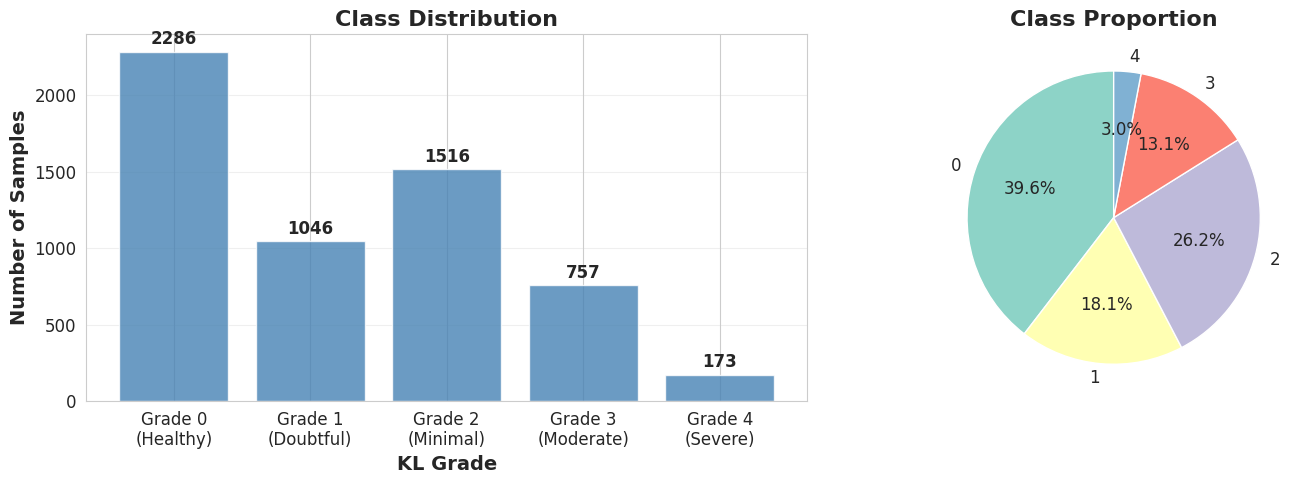


Class Distribution Statistics:
Grade 0:  2286 samples (39.56%)
Grade 1:  1046 samples (18.10%)
Grade 2:  1516 samples (26.24%)
Grade 3:   757 samples (13.10%)
Grade 4:   173 samples ( 2.99%)

Imbalance Ratio: 13.21:1
Most common class: Grade 0 (2286 samples)
Least common class: Grade 4 (173 samples)


In [3]:
# Cell 3: Class Distribution Analysis
"""
Analyze class distribution to understand imbalance
"""

# Count samples per class
class_counts = df['grade'].value_counts().sort_index()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(class_counts.index, class_counts.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('KL Grade', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=14, fontweight='bold')
axes[0].set_title('Class Distribution', fontsize=16, fontweight='bold')
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(['Grade 0\n(Healthy)', 'Grade 1\n(Doubtful)', 
                         'Grade 2\n(Minimal)', 'Grade 3\n(Moderate)', 
                         'Grade 4\n(Severe)'])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, (grade, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 50, str(count), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(5))
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Proportion', fontsize=16, fontweight='bold')
RESULTS_DIR = '../reports/figures/'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR, exist_ok=True)
plt.tight_layout()
plt.savefig('../reports/figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nClass Distribution Statistics:")
print("="*50)
for grade, count in class_counts.items():
    percentage = 100 * count / len(df)
    print(f"Grade {grade}: {count:5d} samples ({percentage:5.2f}%)")
print("="*50)

# Calculate imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Most common class: Grade {class_counts.idxmax()} ({class_counts.max()} samples)")
print(f"Least common class: Grade {class_counts.idxmin()} ({class_counts.min()} samples)")


Analyzing image properties...


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

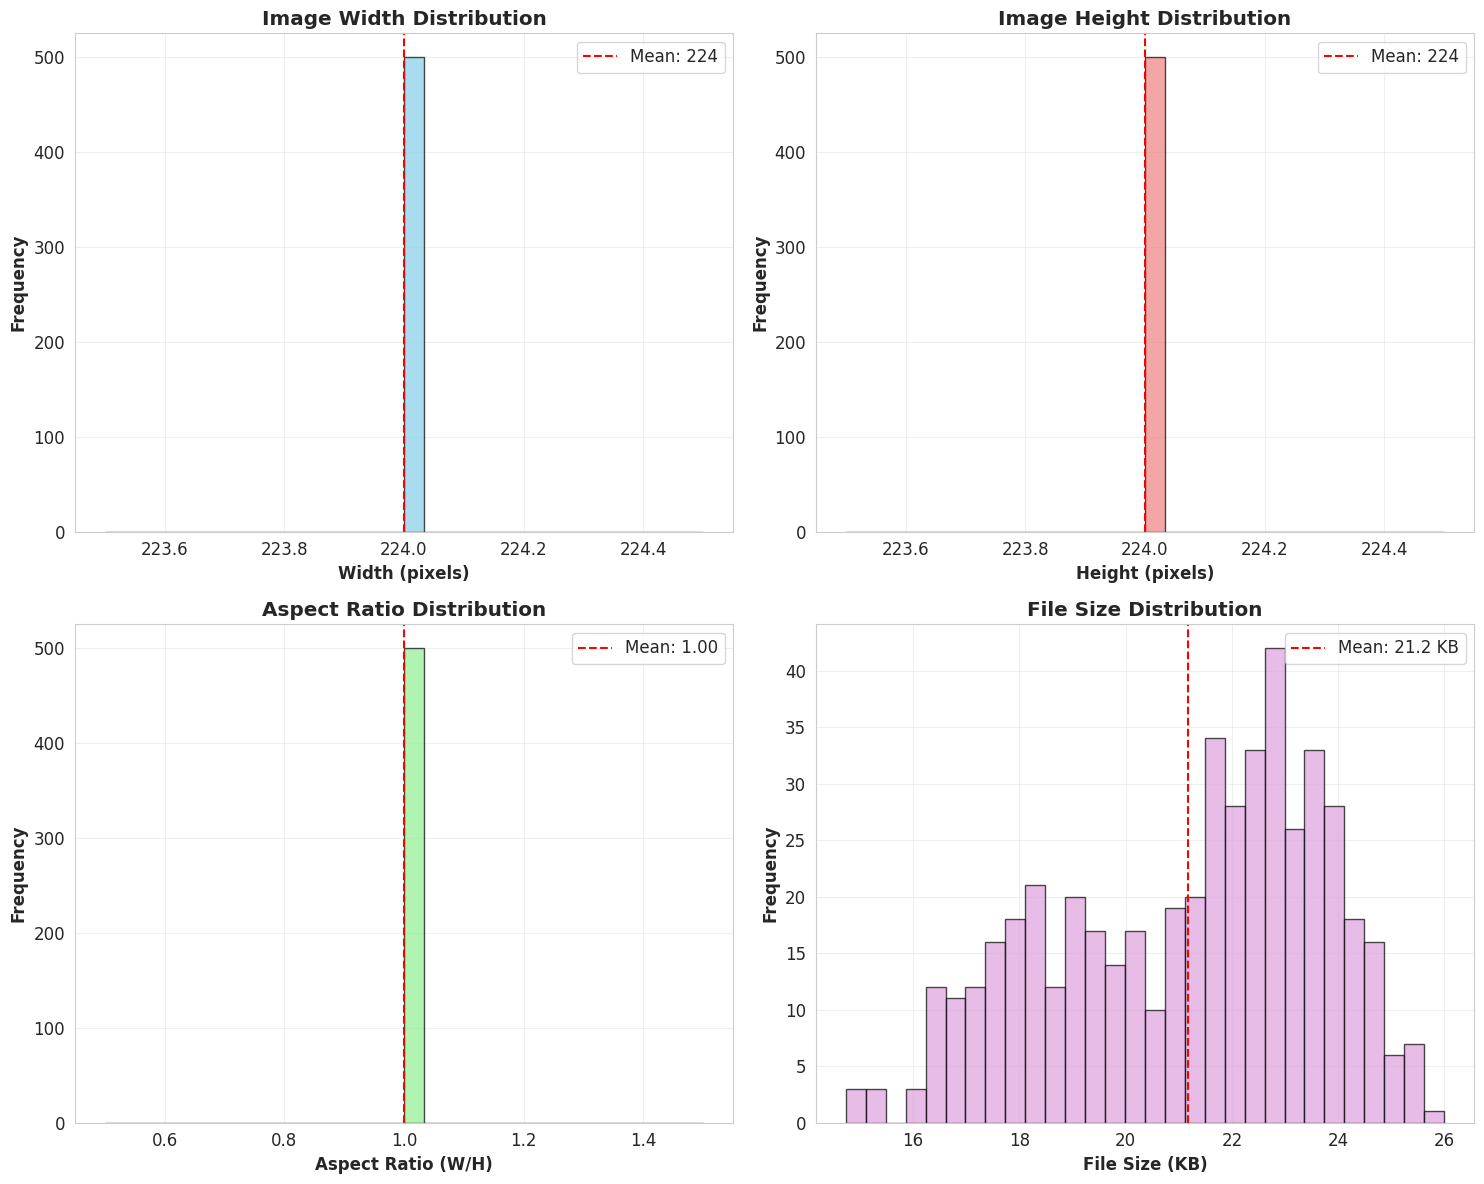

Analyzing image properties...


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

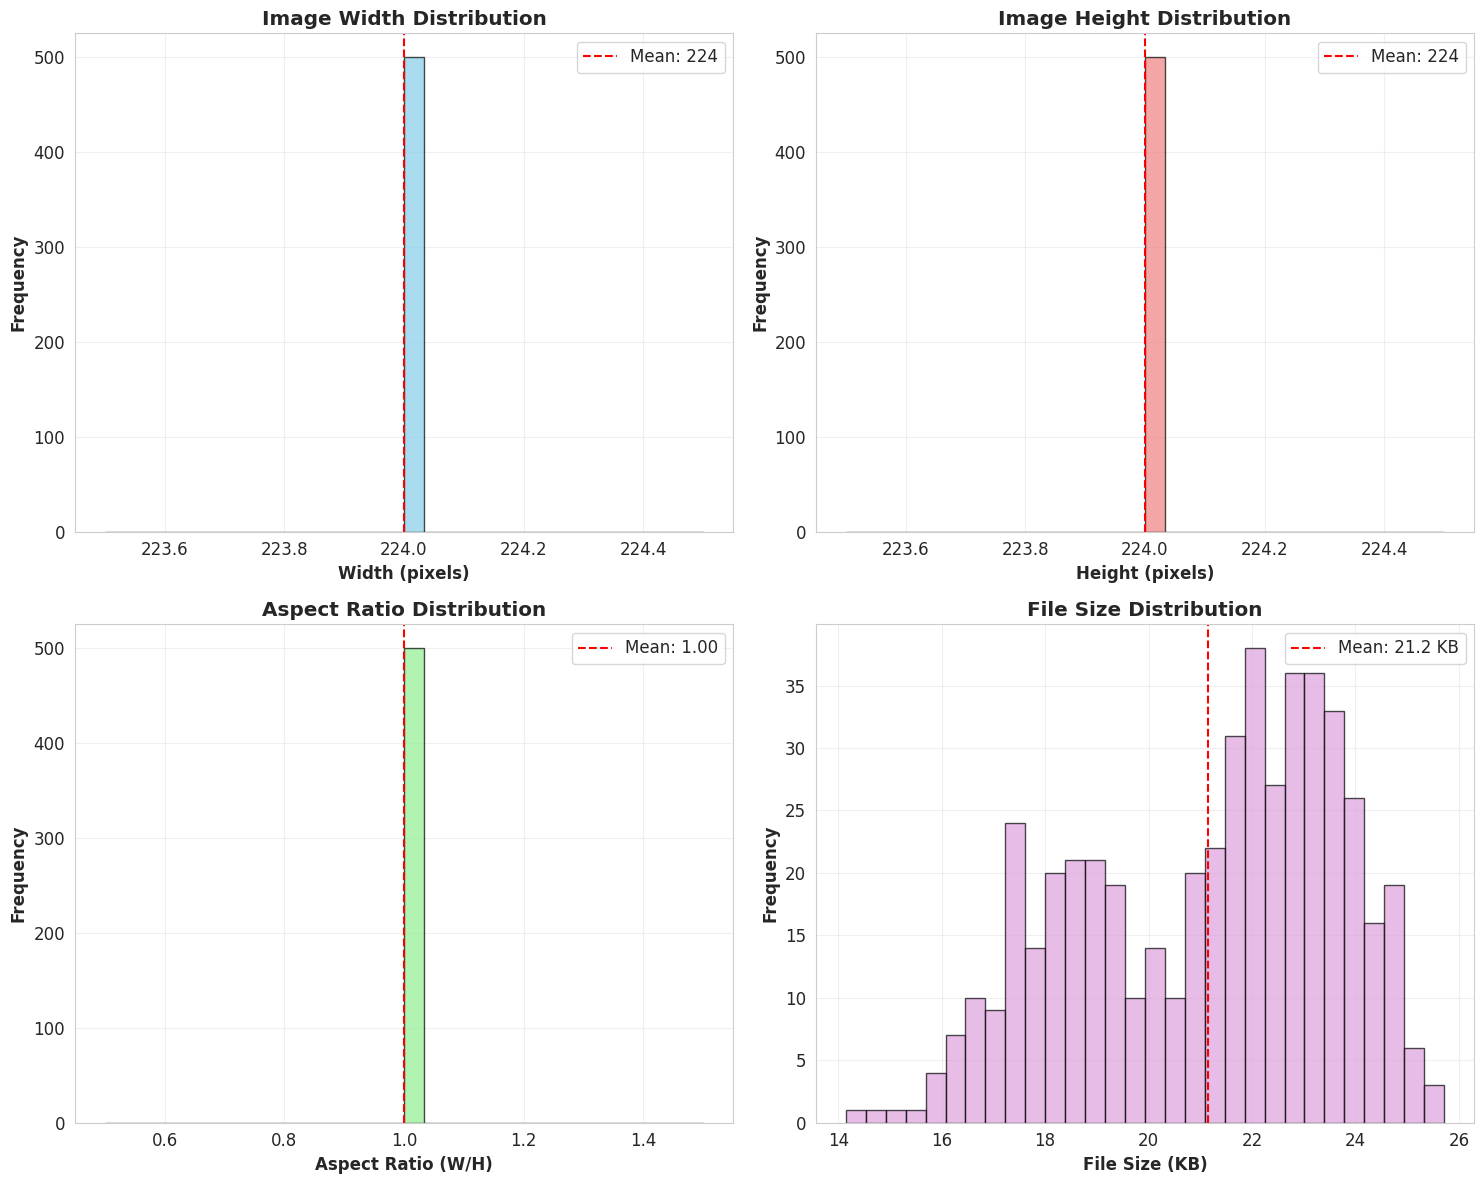

In [4]:
# Cell 4: Image Size Analysis
"""
Analyze image dimensions and aspect ratios
"""

print("Analyzing image properties...")

# Sample images to check
sample_size = min(500, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)

image_stats = {
    'width': [],
    'height': [],
    'aspect_ratio': [],
    'file_size_kb': []
}

for idx in tqdm(sample_indices, desc="Processing images"):
    img_path = df.iloc[idx]['image_path']
    
    # Get image info
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        h, w = img.shape
        image_stats['width'].append(w)
        image_stats['height'].append(h)
        image_stats['aspect_ratio'].append(w / h)
        
        # File size
        file_size = Path(img_path).stat().st_size / 1024  # KB
        image_stats['file_size_kb'].append(file_size)

# Convert to DataFrame
img_df = pd.DataFrame(image_stats)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(img_df['width'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(img_df['width'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {img_df["width"].mean():.0f}')
axes[0, 0].set_xlabel('Width (pixels)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Image Width Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(img_df['height'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(img_df['height'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["height"].mean():.0f}')
axes[0, 1].set_xlabel('Height (pixels)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Image Height Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio
axes[1, 0].hist(img_df['aspect_ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(img_df['aspect_ratio'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["aspect_ratio"].mean():.2f}')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# File size
axes[1, 1].hist(img_df['file_size_kb'], bins=30, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(img_df['file_size_kb'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["file_size_kb"].mean():.1f} KB')
axes[1, 1].set_xlabel('File Size (KB)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('File Size Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/image_properties.png', dpi=300, bbox_inches='tight')
plt.show()
# Cell 4: Image Size Analysis
"""
Analyze image dimensions and aspect ratios
"""

print("Analyzing image properties...")

# Sample images to check
sample_size = min(500, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)

image_stats = {
    'width': [],
    'height': [],
    'aspect_ratio': [],
    'file_size_kb': []
}

for idx in tqdm(sample_indices, desc="Processing images"):
    img_path = df.iloc[idx]['image_path']
    
    # Get image info
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        h, w = img.shape
        image_stats['width'].append(w)
        image_stats['height'].append(h)
        image_stats['aspect_ratio'].append(w / h)
        
        # File size
        file_size = Path(img_path).stat().st_size / 1024  # KB
        image_stats['file_size_kb'].append(file_size)

# Convert to DataFrame
img_df = pd.DataFrame(image_stats)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(img_df['width'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(img_df['width'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {img_df["width"].mean():.0f}')
axes[0, 0].set_xlabel('Width (pixels)', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Image Width Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(img_df['height'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(img_df['height'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["height"].mean():.0f}')
axes[0, 1].set_xlabel('Height (pixels)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Image Height Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio
axes[1, 0].hist(img_df['aspect_ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(img_df['aspect_ratio'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["aspect_ratio"].mean():.2f}')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Aspect Ratio Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# File size
axes[1, 1].hist(img_df['file_size_kb'], bins=30, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(img_df['file_size_kb'].mean(), color='red', linestyle='--',
                    label=f'Mean: {img_df["file_size_kb"].mean():.1f} KB')
axes[1, 1].set_xlabel('File Size (KB)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('File Size Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/image_properties.png', dpi=300, bbox_inches='tight')
plt.show()

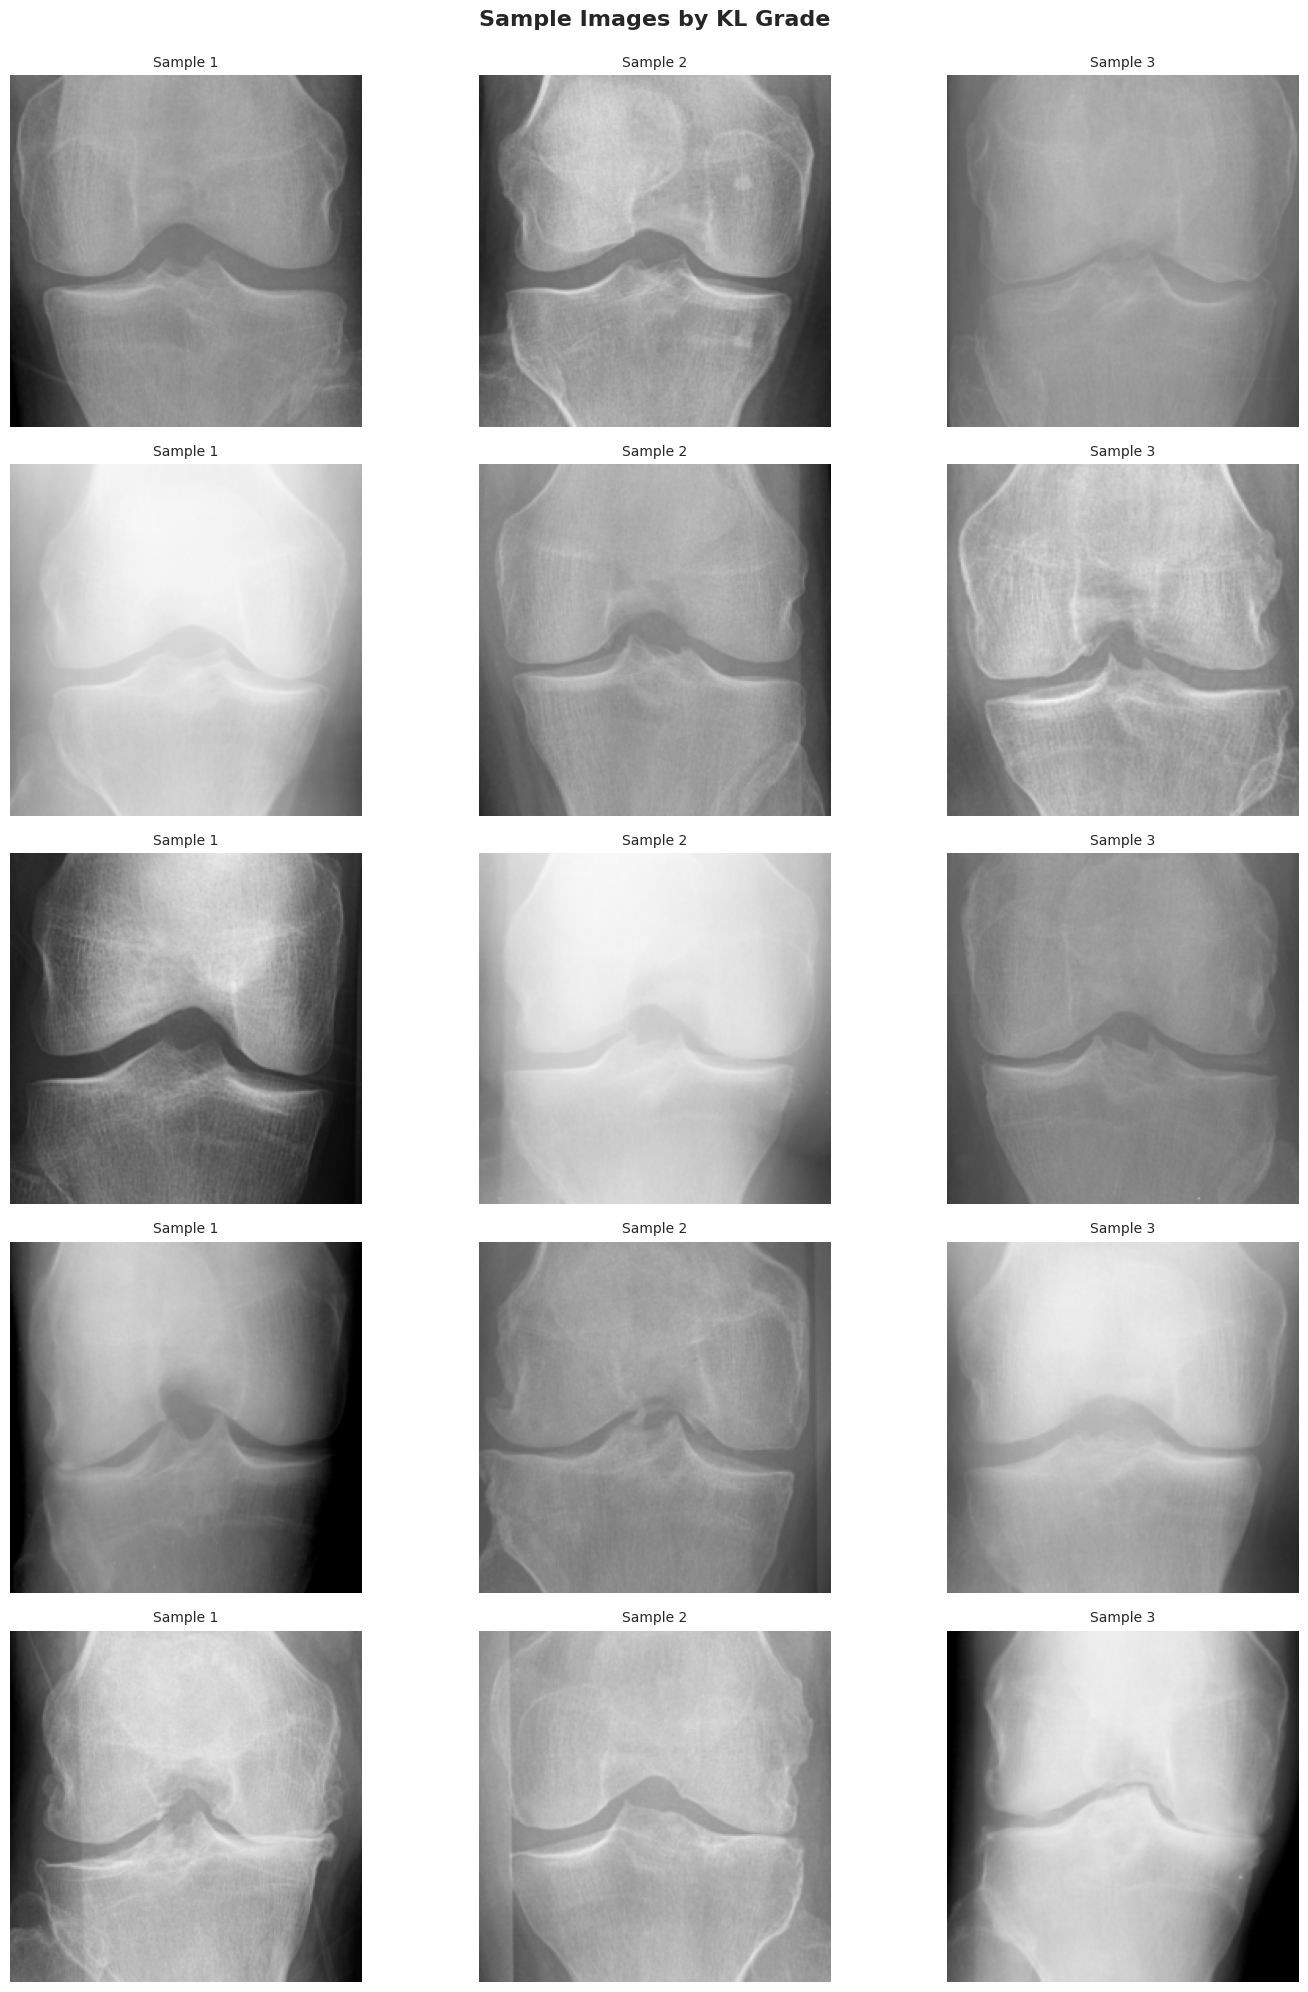

In [5]:
# Cell 5: Visual Inspection of Sample Images
"""
Display sample images from each class
"""

# Select random samples from each class
samples_per_class = 3
fig, axes = plt.subplots(5, samples_per_class, figsize=(15, 20))

for grade in range(5):
    # Get samples for this grade
    grade_df = df[df['grade'] == grade]
    sample_indices = np.random.choice(len(grade_df), samples_per_class, replace=False)
    
    for i, idx in enumerate(sample_indices):
        img_path = grade_df.iloc[idx]['image_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[grade, i].imshow(img)
        axes[grade, i].axis('off')
        
        if i == 0:
            axes[grade, i].set_ylabel(f'Grade {grade}', fontsize=14, fontweight='bold')
        
        axes[grade, i].set_title(f'Sample {i+1}', fontsize=10)

plt.suptitle('Sample Images by KL Grade', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../reports/figures/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

Analyzing pixel intensity distributions...


Grade 0:   0%|          | 0/100 [00:00<?, ?it/s]

Grade 1:   0%|          | 0/100 [00:00<?, ?it/s]

Grade 2:   0%|          | 0/100 [00:00<?, ?it/s]

Grade 3:   0%|          | 0/100 [00:00<?, ?it/s]

Grade 4:   0%|          | 0/100 [00:00<?, ?it/s]

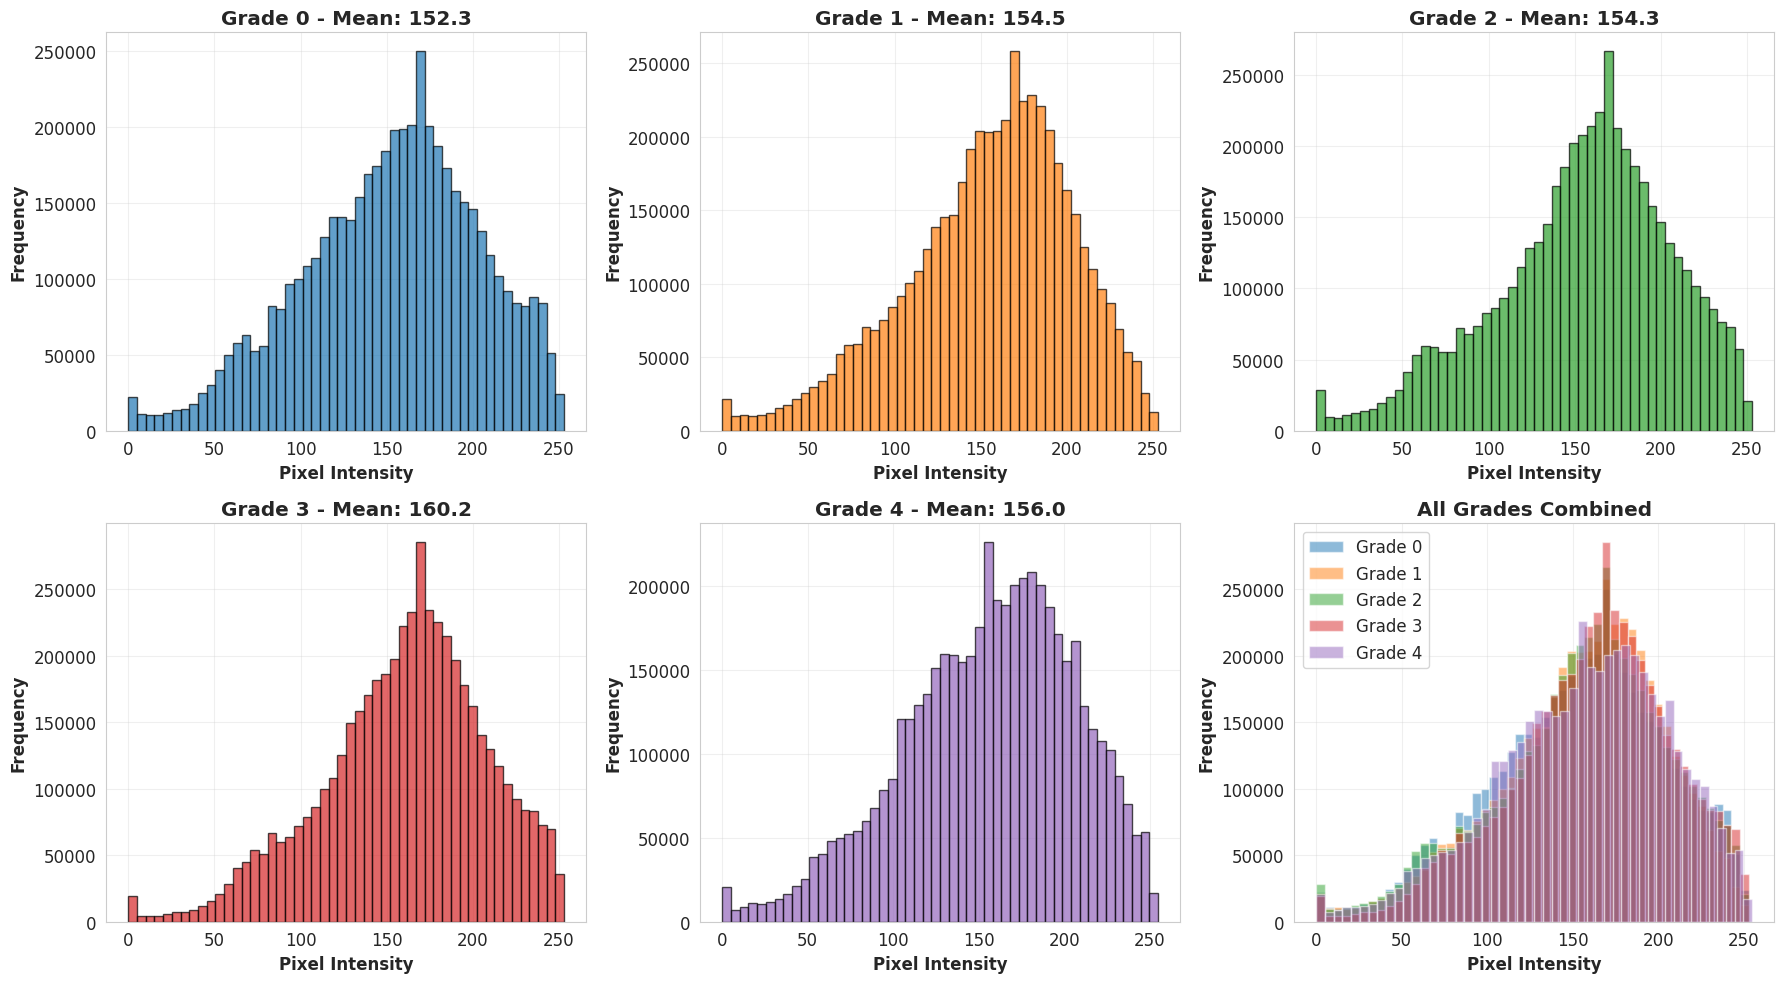

In [6]:
# Cell 6: Pixel Intensity Analysis
"""
Analyze pixel intensity distributions across classes
"""

print("Analyzing pixel intensity distributions...")

intensity_stats = {grade: [] for grade in range(5)}

# Sample images from each class
samples_per_grade = 100

for grade in range(5):
    grade_df = df[df['grade'] == grade]
    sample_indices = np.random.choice(len(grade_df), 
                                     min(samples_per_grade, len(grade_df)), 
                                     replace=False)
    
    for idx in tqdm(sample_indices, desc=f"Grade {grade}"):
        img_path = grade_df.iloc[idx]['image_path']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            intensity_stats[grade].extend(img.flatten())

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for grade in range(5):
    axes[grade].hist(intensity_stats[grade], bins=50, color=colors[grade], 
                     alpha=0.7, edgecolor='black')
    axes[grade].set_xlabel('Pixel Intensity', fontweight='bold')
    axes[grade].set_ylabel('Frequency', fontweight='bold')
    axes[grade].set_title(f'Grade {grade} - Mean: {np.mean(intensity_stats[grade]):.1f}', 
                         fontweight='bold')
    axes[grade].grid(alpha=0.3)

# Combined plot
for grade in range(5):
    axes[5].hist(intensity_stats[grade], bins=50, alpha=0.5, 
                label=f'Grade {grade}', color=colors[grade])
axes[5].set_xlabel('Pixel Intensity', fontweight='bold')
axes[5].set_ylabel('Frequency', fontweight='bold')
axes[5].set_title('All Grades Combined', fontweight='bold')
axes[5].legend()
axes[5].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/intensity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

Split ratios - Train: 70%, Val: 15%, Test: 15%

Total samples: 5778
Train samples: 4044 (70.0%)
Val samples: 867 (15.0%)
Test samples: 867 (15.0%)

Class distribution verification:
Split      | Grade 0    | Grade 1    | Grade 2    | Grade 3    | Grade 4   
Train      | 1600 (39.6%) | 732 (18.1%) | 1061 (26.2%) | 530 (13.1%) | 121 (3.0%)
Val        | 343 (39.6%) | 157 (18.1%) | 228 (26.3%) | 113 (13.0%) | 26 (3.0%) 
Test       | 343 (39.6%) | 157 (18.1%) | 227 (26.2%) | 114 (13.1%) | 26 (3.0%) 


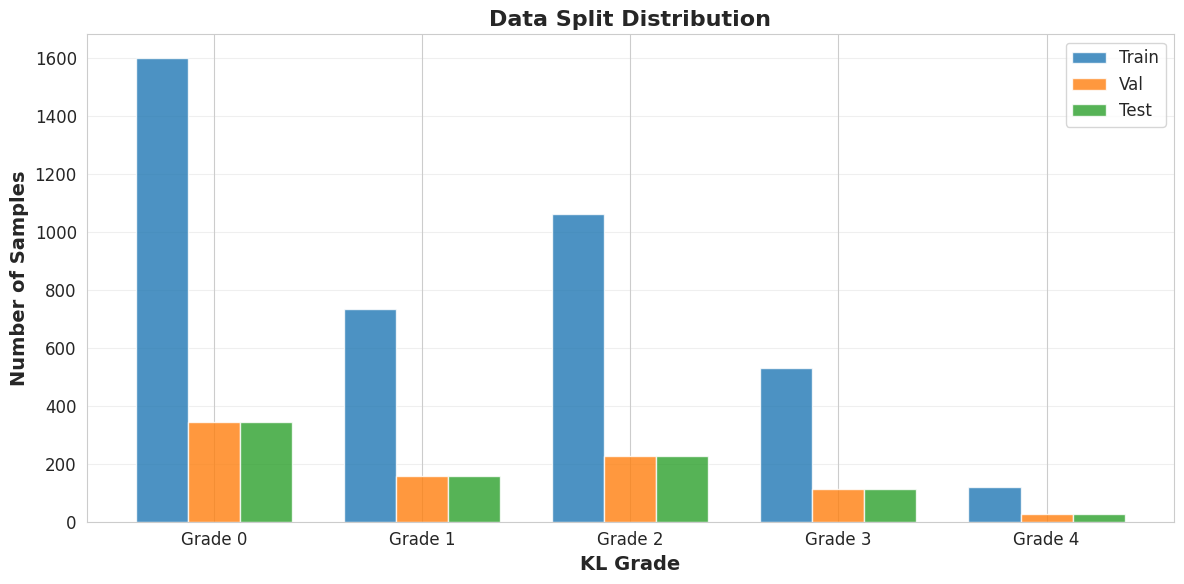


✓ Split metadata saved!


In [7]:
# Cell 7: Data Splitting Strategy
"""
Create train/val/test splits with stratification
"""

from sklearn.model_selection import train_test_split

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Split ratios - Train: {TRAIN_RATIO:.0%}, Val: {VAL_RATIO:.0%}, Test: {TEST_RATIO:.0%}")

# First split: train + val vs test
train_val_df, test_df = train_test_split(
    df, 
    test_size=TEST_RATIO, 
    stratify=df['grade'],
    random_state=42
)

# Second split: train vs val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=VAL_RATIO / (TRAIN_RATIO + VAL_RATIO),
    stratify=train_val_df['grade'],
    random_state=42
)

# Print split info
print(f"\nTotal samples: {len(df)}")
print(f"Train samples: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Val samples: {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df):.1%})")

# Verify stratification
print("\nClass distribution verification:")
print("="*70)
print(f"{'Split':<10} | {'Grade 0':<10} | {'Grade 1':<10} | {'Grade 2':<10} | {'Grade 3':<10} | {'Grade 4':<10}")
print("="*70)

for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    counts = split_df['grade'].value_counts().sort_index()
    percentages = [f"{c} ({100*c/len(split_df):.1f}%)" for c in counts.values]
    print(f"{split_name:<10} | {' | '.join([f'{p:<10}' for p in percentages])}")

print("="*70)

# Visualize split distribution
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.25

train_counts = train_df['grade'].value_counts().sort_index()
val_counts = val_df['grade'].value_counts().sort_index()
test_counts = test_df['grade'].value_counts().sort_index()

ax.bar(x - width, train_counts, width, label='Train', alpha=0.8)
ax.bar(x, val_counts, width, label='Val', alpha=0.8)
ax.bar(x + width, test_counts, width, label='Test', alpha=0.8)

ax.set_xlabel('KL Grade', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=14, fontweight='bold')
ax.set_title('Data Split Distribution', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Grade {i}' for i in range(5)])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
if not PROCESSED_DIR.exists():
    PROCESSED_DIR.mkdir(parents=True)
plt.savefig('../reports/figures/data_split.png', dpi=300, bbox_inches='tight')
plt.show()
# Save splits
train_df.to_csv(PROCESSED_DIR / 'train_metadata.csv', index=False)
val_df.to_csv(PROCESSED_DIR / 'val_metadata.csv', index=False)
test_df.to_csv(PROCESSED_DIR / 'test_metadata.csv', index=False)

print("\n✓ Split metadata saved!")

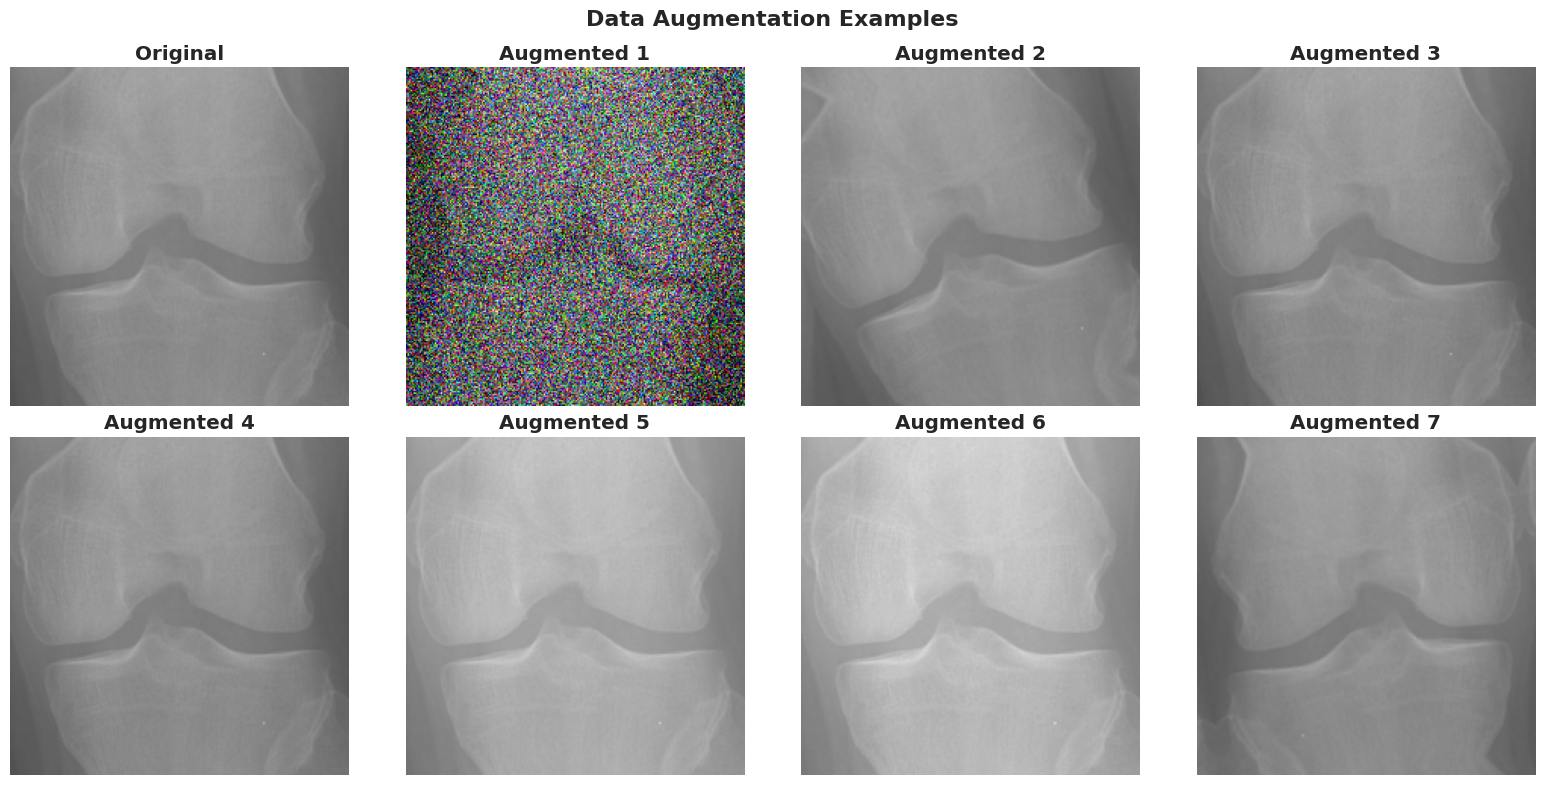

In [8]:
# Cell 8: Image Preprocessing Pipeline
"""
Define and test preprocessing pipeline
"""

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define preprocessing transforms
IMAGE_SIZE = 224

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Test on sample image
sample_img_path = df.iloc[0]['image_path']
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# Apply augmentations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Original
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

# Apply multiple augmentations
for i in range(1, 8):
    augmented = train_transform(image=sample_img)['image']
    # Convert tensor back to numpy for display
    img_np = augmented.permute(1, 2, 0).numpy()
    # Denormalize
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    row = i // 4
    col = i % 4
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f'Augmented {i}', fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Cell 9: Summary Statistics Table
"""
Create comprehensive summary table
"""

summary_data = {
    'Metric': [
        'Total Images',
        'Training Images',
        'Validation Images',
        'Test Images',
        'Number of Classes',
        'Image Size (avg)',
        'File Size (avg)',
        'Imbalance Ratio',
        'Most Common Class',
        'Least Common Class'
    ],
    'Value': [
        len(df),
        len(train_df),
        len(val_df),
        len(test_df),
        5,
        f"{img_df['width'].mean():.0f} x {img_df['height'].mean():.0f}",
        f"{img_df['file_size_kb'].mean():.1f} KB",
        f"{imbalance_ratio:.2f}:1",
        f"Grade {class_counts.idxmax()} ({class_counts.max()} samples)",
        f"Grade {class_counts.idxmin()} ({class_counts.min()} samples)"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)
REPORTS_DIR = Path('../reports/tables/')
if not REPORTS_DIR.exists():
    REPORTS_DIR.mkdir(parents=True)
# Save to CSV
summary_df.to_csv('../reports/tables/dataset_summary.csv', index=False)

print("\n" + "="*50)
print("EDA and Preprocessing Complete!")
print("="*50)
print("\n✓ All figures saved to reports/figures/")
print("✓ Split metadata saved to data/processed/")
print("✓ Summary table saved to reports/tables/")


,Metric,Value
0,Total Images,5778
1,Training Images,4044
2,Validation Images,867
3,Test Images,867
4,Number of Classes,5
5,Image Size (avg),224 x 224
6,File Size (avg),21.2 KB
7,Imbalance Ratio,13.21:1
8,Most Common Class,Grade 0 (2286 samples)
9,Least Common Class,Grade 4 (173 samples)



EDA and Preprocessing Complete!

✓ All figures saved to reports/figures/
✓ Split metadata saved to data/processed/
✓ Summary table saved to reports/tables/
